In [1]:
%run imports.ipynb

### MR relation with fitted power-law function for data without error

In [29]:

workingTableExoplanets = pandas.read_pickle("../data/all_my_systems.pkl")
workingTableExoplanets = workingTableExoplanets[~workingTableExoplanets['mass_detection_type'].isin(['Theoretical'])]

planetstodrop = []
# error cut
for index, row in workingTableExoplanets.iterrows():
    if (abs(workingTableExoplanets.at[index,"radius_error_min"]) + workingTableExoplanets.at[index,"radius_error_max"])/ workingTableExoplanets.at[index,"radius"] >= 1.0:
        planetstodrop.append(index)

    if (abs(workingTableExoplanets.at[index,"mass_error_min"]) +workingTableExoplanets.at[index,"mass_error_max"])/workingTableExoplanets.at[index,"mass"] >= 1.0:
        planetstodrop.append(index)

# print(len(planetstodrop))

workingTableExoplanets = workingTableExoplanets.drop(index=planetstodrop)
workingTableExoplanets = workingTableExoplanets.query("`mass`.notna() & `radius`.notna()")
workingTableExoplanets = workingTableExoplanets.query("`pl_radjlim`.isnull() & `pl_massjlim`.isnull()")
workingTableExoplanets = workingTableExoplanets.query("`radius_error_min`.notna() & `radius_error_max`.notna() & `mass_error_min`.notna() & `mass_error_max`.notna()")
workingTableExoplanets = workingTableExoplanets.sort_values(by=['mass'])
print(f"Systems:{len(numpy.unique(workingTableExoplanets['star_name']))}, planets:{len(workingTableExoplanets)}")
radius = workingTableExoplanets["radius"] * radius_coeff
mass = workingTableExoplanets["mass"]  * mass_coeff
star_age = workingTableExoplanets["star_age"]
star_teff = workingTableExoplanets["star_teff"]
star_mass = workingTableExoplanets["star_mass"]
star_radius = workingTableExoplanets["star_radius"]
star_metallicity = workingTableExoplanets["star_metallicity"]
star_rotp = workingTableExoplanets["st_rotp"]

Exoplanets0 = workingTableExoplanets.iloc[:0,:].copy()
Exoplanets1 = workingTableExoplanets.iloc[:0,:].copy()
Exoplanets2 = workingTableExoplanets.iloc[:0,:].copy()

# uncomment below for sample separated by the pure water line cut-off
## waterline
for index, row in workingTableExoplanets.iterrows():
    if row["mass"] * mass_coeff.value > numpy.max(curves.index.values):
        Exoplanets0 = Exoplanets0.append([row])

    else:
        mass_z = row["mass"] * mass_coeff.value
        if row["radius"] * radius_coeff.value > numpy.interp(mass_z, curves.index.values, curves["100%H2O"].values):
            Exoplanets1 = Exoplanets1.append(row)
        else:
            Exoplanets2 = Exoplanets2.append(row)

# uncomment below for sample separated by the pure water line cut-off
## density cutoffs
# workingTableExoplanets["density"] = (workingTableExoplanets["mass"]  * mass_coeff * constants.M_earth.value/ (4 / 3 * numpy.pi * ((workingTableExoplanets["radius"] * radius_coeff * constants.R_earth.value) ** 3)))
# for index, row in workingTableExoplanets.iterrows():
#     if row["mass"] * mass_coeff.value > numpy.max(curves.index.values):
#         Exoplanets0 = Exoplanets0.append([row])
#     elif row["density"] < 3300.:
#         Exoplanets1 = Exoplanets1.append(row)
#     else:
#         Exoplanets2 = Exoplanets2.append(row)

# with pandas.option_context('display.max_rows', None, 'display.max_columns', None):
#     display(Exoplanets0)
# with pandas.option_context('display.max_rows', None, 'display.max_columns', None):
#     display(Exoplanets1)
# with pandas.option_context('display.max_rows', None, 'display.max_columns', None):
#     display(Exoplanets2)
def f2(x, a0, a1):
    return a0 * x ** a1

y1 = Exoplanets1["radius"] * radius_coeff
x1 = Exoplanets1["mass"] * mass_coeff
p_zero1 = [1.03,0.29]
popt1, pcov1 = scipy.optimize.curve_fit(f2, x1, y1, p0=p_zero1, method='lm')
#
print(f"Function fit y (radius) to x data column (mass) for voaltile-rich: R = {format(popt1[0],'.2f')} * M ** {format(popt1[1],'.2f')}")
print("Parameters from least-squares fit:")
print("a0 =", popt1[0], "+/-", pcov1[0,0]**0.5)
print("a1 =", popt1[1], "+/-", pcov1[1,1]**0.5)
p_zero2 = [0.7,0.63]
y2 = Exoplanets2["radius"] * radius_coeff
x2 = Exoplanets2["mass"] * mass_coeff
popt2, pcov2 = scipy.optimize.curve_fit(f2, x2, y2, p0=p_zero2, method='lm')
#
print(f"Function fit y (radius) to x data column (mass) for rocky: R = {format(popt2[0],'.2f')} * M ** {format(popt2[1],'.2f')}")
print("Parameters from least-squares fit:")
print("a0 =", popt2[0], "+/-", pcov2[0,0]**0.5)
print("a1 =", popt2[1], "+/-", pcov2[1,1]**0.5)



Systems:101, planets:201
Function fit y (radius) to x data column (mass) for voaltile-rich: R = 1.55 * M ** 0.41
Parameters from least-squares fit:
a0 = 1.5451738489348372 +/- 0.26680792996568475
a1 = 0.40832683460740393 +/- 0.06734666139394582
Function fit y (radius) to x data column (mass) for rocky: R = 1.18 * M ** 0.24
Parameters from least-squares fit:
a0 = 1.1787839781849931 +/- 0.06070210829493989
a1 = 0.2435895165662159 +/- 0.02284279048854255


### Calculation of the fitted function coefficients using the error accommodating routine for volatile-rich population, the coefficient distributions

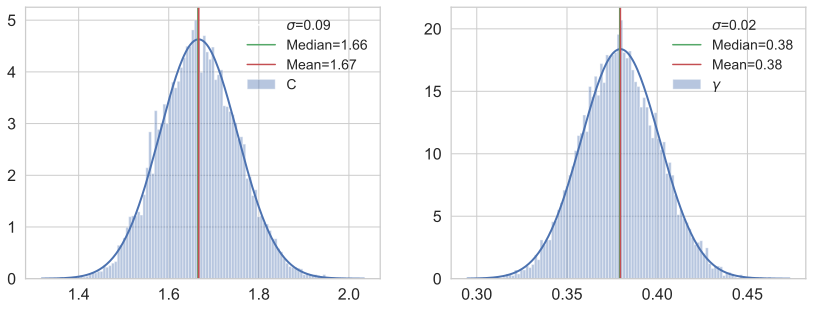

In [30]:
counts = 10000

radiusExoplanets1 = numpy.zeros((len(Exoplanets1), counts))
massExoplanets1 = numpy.zeros((len(Exoplanets1), counts))

j = 0
for index, row in Exoplanets1.iterrows():

    massExo = []
    radiusExo = []
    upperLimitMass = (row["mass_error_max"] + row["mass"])  * mass_coeff
    lowerLimitMass = (row["mass"] - abs(row["mass_error_min"])) * mass_coeff
    massExo = numpy.random.uniform(upperLimitMass, lowerLimitMass, counts)
    massExoplanets1[j] = massExo

    upperLimitRadius = (row["radius_error_max"] + row["radius"])  * radius_coeff
    lowerLimitRadius = (row["radius"] - abs(row["radius_error_min"]))  * radius_coeff
    radiusExo = numpy.random.uniform(upperLimitRadius, lowerLimitRadius, counts)
    radiusExoplanets1[j] = radiusExo
    j +=1

a0Massive = []
a0Massivepcov = []

a1Massive = []
a1Massivepcov = []

for i in range(counts):
    popt3 = 0.
    pcov3 = 0.
    y1 = []
    x1 = []
    for k in range(len(Exoplanets1)):
        y1.append(radiusExoplanets1[k][i])
        x1.append(massExoplanets1[k][i])
        # p_zero1 = [1.03,0.29] p0=p_zero1,
    popt3, pcov3 = scipy.optimize.curve_fit(f2, x1, y1, method='lm')
    a0Massive.append(popt3[0])
    a0Massivepcov.append(pcov3[0,0]**0.5)
    a1Massive.append(popt3[1])
    a1Massivepcov.append(pcov3[1,1]**0.5)

fig, ax = plt.subplots(1,2,figsize=(14,5))

data = numpy.array(a0Massive)

seaborn.set(rc={'figure.figsize':(14,5)})

seaborn.cubehelix_palette(start=-.2,rot=.6, as_cmap=True)
seaborn.set_theme(style="whitegrid")
h = seaborn.distplot(data, hist=True, norm_hist=True, kde=False, fit=norm, fit_kws={"color": "b", "lw": 2},bins=100, hist_kws={"weights":None, "density":True, "color": "b"}, ax=ax[0], label=f"C")
data1 = numpy.array(a1Massive)
h1 = seaborn.distplot(data1, hist=True, norm_hist=True, kde=False, fit=norm, fit_kws={"color": "b", "lw": 2},bins=100, hist_kws={"weights":None, "density":True, "color": "b"}, ax=ax[1], label=f"$\gamma$")

ax[0].axvline(x=data.mean(),color='r')
c=numpy.median(data)

b=numpy.median(data1)
e = data.mean()
d = data1.mean()
c=numpy.median(data)
b=numpy.median(data1)
f=data1.std()
ax[0].plot(c,h.get_ylim()[0], color='w', label=f"$\sigma$={data.std().round(2)}", zorder=0)

ax[0].axvline(x=c,color='g', label=f"Median={format(c,'.2f')}")

ax[0].axvline(x=e,color='r', label=f"Mean={format(e,'.2f')}")
ax[1].plot(b,h1.get_ylim()[0], color='w', label=f"$\sigma$={data1.std().round(2)}", zorder=0)

ax[1].axvline(x=b,color='g', label=f"Median={format(b,'.2f')}")
ax[1].axvline(x=d,color='r', label=f"Mean={format(d,'.2f')}")
ax[0].legend(loc="upper right", prop={"size":14}, frameon=False)
ax[1].legend(loc="upper right", prop={"size":14}, frameon=False)
ax[0].tick_params(axis='both', which='major', labelsize=16)
plt.grid()
ax[1].tick_params(axis='both', which='major', labelsize=16)
plt.grid()
# MR waterline range coeff for Rocky
plt.savefig("MR_waterline_range_coeffVolat.png",bbox_inches="tight")
plt.savefig("MR_waterline_range_coeffVolat.svg",bbox_inches="tight")
# MR density range coeff for Rocky
# plt.savefig("MR_2density_range_coeffVolat.png",bbox_inches="tight")
# plt.savefig("MR_2density_range_coeffVolat.svg",bbox_inches="tight")
plt.show()

### Calculation of the fitted function coefficients using the error accommodating routine for rocky population, the coefficient distributions

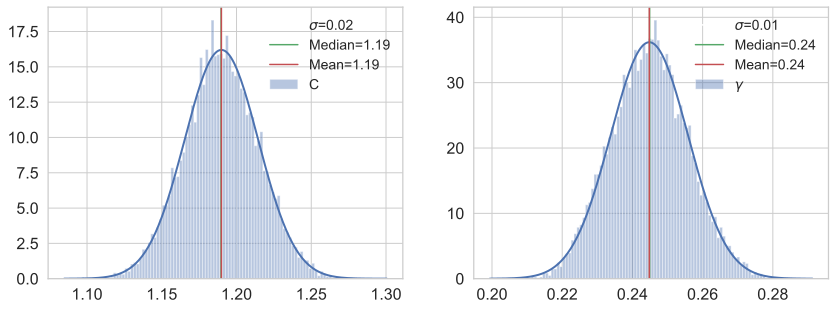

In [31]:

counts = 10000

radiusExoplanets2 = numpy.zeros((len(Exoplanets2), counts))
massExoplanets2 = numpy.zeros((len(Exoplanets2), counts))

j = 0
for index, row in Exoplanets2.iterrows():

    massExo = []
    radiusExo = []
    upperLimitMass = (row["mass_error_max"] + row["mass"])  * mass_coeff
    lowerLimitMass = (row["mass"] - abs(row["mass_error_min"])) * mass_coeff
    massExo = numpy.random.uniform(upperLimitMass, lowerLimitMass, counts)
    massExoplanets2[j] = massExo

    upperLimitRadius = (row["radius_error_max"] + row["radius"])  * radius_coeff
    lowerLimitRadius = (row["radius"] - abs(row["radius_error_min"]))  * radius_coeff
    radiusExo = numpy.random.uniform(upperLimitRadius, lowerLimitRadius, counts)
    radiusExoplanets2[j] = radiusExo
    j +=1

a0Massive2 = []
a0Massivepcov2 = []

a1Massive2 = []
a1Massivepcov2 = []

for i in range(counts):
    popt4 = 0.
    pcov4 = 0.
    y2 = []
    x2 = []
    for k in range(len(Exoplanets2)):
        y2.append(radiusExoplanets2[k][i])
        x2.append(massExoplanets2[k][i])
    popt4, pcov4 = scipy.optimize.curve_fit(f2, x2, y2, method='lm')
    a0Massive2.append(popt4[0])
    a0Massivepcov2.append(pcov4[0,0]**0.5)
    a1Massive2.append(popt4[1])
    a1Massivepcov2.append(pcov4[1,1]**0.5)
fig, ax = plt.subplots(1,2,figsize=(14,5))

data = numpy.array(a0Massive2)

seaborn.set(rc={'figure.figsize':(14,5)})

seaborn.cubehelix_palette(start=-.2,rot=.6, as_cmap=True)
seaborn.set_theme(style="whitegrid")
h = seaborn.distplot(data, hist=True, norm_hist=True, kde=False, fit=norm, fit_kws={"color": "b", "lw": 2},bins=100, hist_kws={"weights":None, "density":True, "color": "b"}, ax=ax[0], label=f"C")
data1 = numpy.array(a1Massive2)
h1 = seaborn.distplot(data1, hist=True, norm_hist=True, kde=False, fit=norm, fit_kws={"color": "b", "lw": 2},bins=100, hist_kws={"weights":None, "density":True, "color": "b"}, ax=ax[1], label=f"$\gamma$")
c=numpy.median(data)
b=numpy.median(data1)
e = data.mean()
d = data1.mean()
c=numpy.median(data)
b=numpy.median(data1)

ax[0].plot(c,h.get_ylim()[0], color='w', label=f"$\sigma$={data.std().round(2)}", zorder=0)
ax[0].axvline(x=c,color='g', label=f"Median={format(c,'.2f')}")
ax[0].axvline(x=e,color='r', label=f"Mean={format(e,'.2f')}")
ax[1].plot(b,h1.get_ylim()[0], color='w', label=f"$\sigma$={data1.std().round(2)}", zorder=0)
ax[1].axvline(x=b,color='g', label=f"Median={format(b,'.2f')}")
ax[1].axvline(x=d,color='r', label=f"Mean={format(d,'.2f')}")

ax[0].legend(loc="upper right", prop={"size":14}, frameon=False)
ax[1].legend(loc="upper right", prop={"size":14}, frameon=False)
ax[0].tick_params(axis='both', which='major', labelsize=16)
ax[1].tick_params(axis='both', which='major', labelsize=16)

# MR waterline range coeff for Rocky
plt.savefig("MR_waterline_range_coeffRocky.png",bbox_inches="tight")
plt.savefig("MR_waterline_range_coeffRocky.svg",bbox_inches="tight")
# MR density range coeff for Rocky
# plt.savefig("MR_2density_range_coeffRocky.png",bbox_inches="tight")
# plt.savefig("MR_2density_range_coeffRocky.svg",bbox_inches="tight")
plt.show()

## The Mass-Radius relation for the sample, separated either by pure water line or density cut-off.
### Fitted MRR (green) and the fitted MRR with calculated coefficient from the "error-accommodating" routine (red)

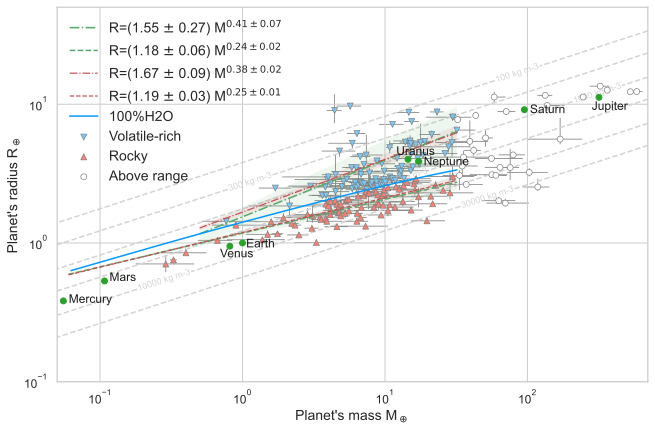

In [33]:

fig, ax = plt.subplots(figsize=(10.6,6.9))
plt.grid()
ax.yaxis.grid()
ax.xaxis.grid()# grid lines
ax.set_axisbelow(True)

m1 = numpy.linspace(0.06,32,100)
m2 = numpy.linspace(0.5,32,100)

ax.set(xscale="log", yscale="log")
ax.yaxis.grid()
ax.xaxis.grid()# grid lines
ax.set_axisbelow(True)
xL = 5e-2
xR = 700.
yB = 1e-1
yT = 50.
ax.set_ylim((yB, yT))
ax.set_xlim((xL, xR))

# plt.grid()
s011 = round(popt1[0],2)
s111 = round(pcov1[0,0]**0.5,2)
s012 = round(popt1[1],2)
s112 = round(pcov1[1,1]**0.5,2)
# #
s021 = round(popt2[0],2)
s121 = round(pcov2[0,0]**0.5,2)
s022 = round(popt2[1],2)
s122 = round(pcov2[1,1]**0.5,2)

plt.plot(m2, f2(m2, popt1[0], popt1[1]), color='g', linestyle= '-.', zorder=1, label=f'R=({s011} $\pm$ {s111}) M$^{{{s012} \pm {s112}}}$')
plt.plot(m1, f2(m1, popt2[0], popt2[1]), color='g', linestyle= '--', zorder=1, label=f'R=({s021} $\pm$ {s121}) M$^{{{s022} \pm {s122}}}$')
plt.fill_between(m2, (s011-s111) * m2  ** (s012- s112), (s011+s111) * m2  ** (s012+s112), facecolor='g',alpha=0.1)
plt.fill_between(m1, (s021-s121) * m1  ** (s022- s122), (s021+s121) * m1  ** (s022+s122), facecolor='g',alpha=0.1)

## uncomment below for median a0,a1 for density with the sum of errors < 1.0
# plt.plot(m2, numpy.power(m2, 0.41) * 1.51, linewidth=1.2, linestyle='-.', color='r', label=f'R= (1.51 $\pm$ 0.07) M$^{{0.41 \pm 0.02 }}$')
# # new 1.51 $\pm$ 0.07 &  0.41 $\pm$ 0.02
# plt.plot(m1, numpy.power(m1, 0.26) * 1.13, linewidth=1.2, linestyle='--', color='r', label=f'R= (1.13 $\pm$ 0.03) M$^{{0.26 \pm 0.01}}$')
# # new 1.13 $\pm$ 0.03 &  0.26 $\pm$ 0.01
# plt.fill_between(m1, numpy.power(m1, 0.26-0.01) * (1.13 - 0.03),numpy.power(m1, 0.26+0.01) * (1.13 + 0.03),facecolor='r',alpha=0.1)
# plt.fill_between(m2,numpy.power(m2, 0.41-0.02) * (1.51-0.07),numpy.power(m2, 0.41+0.02) * (1.51+0.07),facecolor='r',alpha=0.1)

## uncomment below for median a0,a1 for waterline with the sum of errors < 1.0
plt.plot(m2, numpy.power(m2, 0.38) * 1.67, linewidth=1.2, linestyle='-.', color='r', label=f'R=(1.67 $\pm$ 0.09) M$^{{0.38 \pm 0.02 }}$')
plt.plot(m1, numpy.power(m1, 0.25) * 1.19, linewidth=1.2, linestyle='--', color='r', label=f'R=(1.19 $\pm$ 0.03) M$^{{0.25 \pm 0.01}}$')

plt.fill_between(m1, numpy.power(m1, 0.25-0.021) * (1.19 - 0.03),numpy.power(m1, 0.25+0.01) * (1.19 + 0.03),facecolor='r',alpha=0.1)
plt.fill_between(m2,numpy.power(m2, 0.38-0.02) * (1.67 - 0.09),numpy.power(m2, 0.38+0.02) * (1.67 + 0.09),facecolor='r',alpha=0.1)

levelsZ = ["100%Fe", "30%Fe", "rocky", "40%H2O","100%H2O"]
colors=['#E7340E','#C16228', '#DF9706', '#1EB70C', '#0398FF']
ax.plot(curves[levelsZ[4]], color=colors[4], zorder=1, label=levelsZ[4])

xerr = numpy.nan_to_num(workingTableExoplanets[["mass_error_min", "mass_error_max"]].to_numpy().T, posinf=0.) * mass_coeff
yerr = numpy.nan_to_num(workingTableExoplanets[["radius_error_min", "radius_error_max"]].to_numpy().T, posinf=0.) * radius_coeff

ax.errorbar(mass, radius, xerr=numpy.abs(xerr), yerr=numpy.abs(yerr), ls='none', fmt='0.8', ecolor='tab:gray', elinewidth=0.8, capsize=None, barsabove=True, zorder=0)

im1 = ax.scatter(Exoplanets1["mass"] * mass_coeff, Exoplanets1["radius"] * radius_coeff,marker="v", label="Volatile-rich", facecolor="#7BC8F6", edgecolor="tab:gray", linewidths=0.7)
im2 = ax.scatter(Exoplanets2["mass"] * mass_coeff,Exoplanets2["radius"] * radius_coeff, marker="^", label="Rocky", facecolor="#FA8072",edgecolor="tab:gray", linewidths=0.7)
im3 = ax.scatter(Exoplanets0["mass"] * mass_coeff,Exoplanets0["radius"] * radius_coeff,marker="o", label="Above range", facecolor='w', edgecolor="tab:gray", linewidths=0.7)

solarsystemTable = pandas.read_pickle("../data/solarsystemE.pkl")
massS = solarsystemTable["massJ"] * mass_coeff

radiusS = solarsystemTable["radiusJ"] * radius_coeff

solarsysS = ax.scatter(massS, radiusS, marker="o", facecolor='tab:green')

plt.text(massS[0]+.005, radiusS[0]-.012, "Mercury", color="k", fontsize=12, zorder=1)

plt.text(massS[1]-.12, radiusS[1]-.16, "Venus", color="k", fontsize=12, zorder=1)
plt.text(massS[2]+.06, radiusS[2]-.07, "Earth", color="k", fontsize=12, zorder=1)
plt.text(massS[3]+.009, radiusS[3]+.0, "Mars", color="k", fontsize=12, zorder=1)

plt.text(massS[4]-35, radiusS[4]-2.1, "Jupiter", color="k", fontsize=12, zorder=1)
plt.text(massS[5]+9, radiusS[5]-0.5, "Saturn", color="k", fontsize=12, zorder=1)
plt.text(massS[6]-2.5, radiusS[6]+.3, "Uranus", color="k", fontsize=12, zorder=3)
plt.text(massS[7]+1.5, radiusS[7]-.25, "Neptune", color="k", fontsize=12, zorder=1)

nx, ny = (200, 200)
xllog = numpy.log10(xL)
xrlog = numpy.log10(xR)
yllog = numpy.log10(yB)
yrlog = numpy.log10(yT)

massgrid = numpy.logspace(xllog, xrlog, nx)
raduisgrid = numpy.logspace(yllog,yrlog, ny)
massgridX, raduisgridY = numpy.meshgrid(massgrid, raduisgrid)

rho = [100,300,1000,3000,10000,30000]
density = (3 * massgridX * constants.M_earth.value)/ (4 * numpy.pi * (raduisgridY * constants.R_earth.value) ** 3)
contourplotD = ax.contour(massgridX, raduisgridY, density, levels=rho, colors=['#D3D3D3'], extend='both',linestyles='dashed',zorder=0)
ax.clabel(contourplotD, contourplotD.levels, fontsize=9, inline=1, inline_spacing=1, fmt='%1.0f kg m-3', use_clabeltext=True, zorder=0)

plt.grid()

ax.legend(loc="upper left", prop={"size":14}, frameon=False)
ax.set_xlabel("Planet's mass M$_\oplus$", fontsize=14)
ax.set_ylabel("Planet's radius R$_\oplus$", fontsize=14)
plt.tick_params(axis='both', which='major', labelsize=12)

# plt.savefig("MR_2density_range_wr.png",bbox_inches="tight")
# plt.savefig("MR_2density_range_wr.svg",bbox_inches="tight")
plt.savefig("MR_waterline_range_wr.png",bbox_inches="tight")
plt.savefig("MR_waterline_range_wr.svg",bbox_inches="tight")
plt.show()